# Plot Heating Profiles

We are really lucking to have the ICON restart files. Fortunately, they contain much more additional data that are very helpful, e.g. short- and longwave heating profile.

The profiles will be combined with cloud cover information stroed in standard output.

## Import Libraries

In [1]:
%matplotlib inline

import sys, os
import datetime
import numpy as np
import xarray as xr
import importlib

import pylab as plt
plt.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
sns.set_context( 'talk' )


# import nawdex_analysis.io.tools

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import sys
sys.path.append('%s/proj/2017-11_icon-de-lem-analysis/tools' % os.environ['HOME'])

In [3]:
import domain_budgets, input_regrid5km
importlib.reload( input_regrid5km )

<module 'input_regrid5km' from '/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py'>

## Open Files

### Heating Profiles

In [4]:

######################################################################
######################################################################

import os
import numpy as np
import xarray as xr
import nawdex_analysis.io.tools

######################################################################
######################################################################

def input_data4exp(dom = 'DOM01', mode = 'absorbing', regrid_method = 'nn', time_string = '0000Z'):
            
    '''
    Returns regridded simulation restart data (pre-selected variables).

    
    Parameters
    ----------
    dom : ('DOM01', 'DOM02'), optional
        select grid spacing via domain argument

    mode : ('absorbing', 'scattering'), optional
        if sim with or w/o absorption is taken

    
    Returns
    -------
    d : xr.Dataset
        regridded restart data read from disk


    Notes
    -----
    Nearest neighbor regridding used starting from restart data.
    '''

    # select sim experiment
    if mode == 'absorbing':
        subpath = '20130502_CCN_rad'
    elif mode == 'scattering':
        subpath = '20130502_semi_direct_effect'
    
    if dom == 'DOM01':
        region_str = 'R0625m'
    elif dom == 'DOM02':
        region_str = 'nest_R0312m'
    
   
    # read data
    if regrid_method == 'nn':
        fdir = '%s/icon-lem/restart_columns/%s' % (os.environ['LOCAL_DATA_PATH'], subpath )
    else:
        fdir = '%s/icon-lem/%s/RESTART/' % (os.environ['LOCAL_DATA_PATH'], subpath )
    

    fname = '%s/hdcp2_cosmodom_%s_restart_atm_20130502T*%s_subset_regrid5km.nc' % (fdir, region_str, time_string)
    
    d = xr.open_mfdataset( fname, chunks = {'time': 1}, combine='by_coords' )
    # d = d.expand_dims( 'time')
    # patch time vector
    time_vector = nawdex_analysis.io.tools.convert_timevec( d.time.data )
    d['time'] = time_vector
    
    d = d.expand_dims(['mode','dom'])
    d['mode'] = [mode, ]
    d['dom']  = [dom, ]
    
    return d

######################################################################
######################################################################


def input_data( regrid_method = 'nn', time_string = '0000Z' ):
       
    '''
    Returns combination of all regridded restart data.

    
    Returns
    -------
    d : xr.Dataset
        regridded simulation read from disk
    '''

    dlist = []
    
    for dom in ['DOM01', 'DOM02']:
        for mode in['absorbing', 'scattering']:
            
            d_input = input_data4exp(dom = dom, 
                                     mode = mode, 
                                     regrid_method = regrid_method, 
                                     time_string = time_string)
            
            d_resampled = d_input #temporal_resampling( d_input )
            
            dlist += [d_resampled.copy(), ]
            
    return xr.merge( dlist, join = 'outer' )


In [5]:
kws = dict( regrid_method = 'interpolation', time_string = '110000Z' )
t = datetime.datetime(2013, 5, 2, 11, 0)

dset_heating = input_data( **kws )



In [6]:
dset_heating

<xarray.Dataset>
Dimensions:                (depth: 8, depth_2: 9, depth_3: 1, depth_4: 1, dom: 2, height: 1, height_2: 1, lat: 155, lev: 150, lev_2: 151, lev_3: 2, lev_4: 3, lon: 139, mode: 2, time: 1)
Coordinates:
  * dom                    (dom) object 'DOM01' 'DOM02'
  * mode                   (mode) object 'absorbing' 'scattering'
  * time                   (time) datetime64[ns] 2013-05-02T11:00:00
  * lon                    (lon) float64 4.5 4.572 4.643 ... 14.22 14.3 14.37
  * lat                    (lat) float64 47.5 47.54 47.59 ... 54.32 54.37 54.41
  * lev_2                  (lev_2) float64 1.0 2.0 3.0 4.0 ... 149.0 150.0 151.0
  * lev                    (lev) float64 1.0 2.0 3.0 4.0 ... 148.0 149.0 150.0
  * height                 (height) float64 10.0
  * depth                  (depth) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * height_2               (height_2) float64 2.0
  * depth_2                (depth_2) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * lev_3                  (lev_3) float64 1.0 2.0
  * lev_4                  (lev_4) float64 1.0 2.0 3.0
  * depth_3                (depth_3) float64 1.0
  * depth_4                (depth_4) float64 1.0
Data variables:
    w.TL1                  (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    rho.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    theta_v.TL1            (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    exner.TL1              (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qv.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qc.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qi.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qr.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qs.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qg.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qh.TL1                 (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qni.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnr.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qns.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qng.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnh.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    qnc.TL1                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    ninact.TL1             (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    tke.TL1                (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    w.TL3                  (mode, dom, time, lev_2, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 151, 155, 139), meta=np.ndarray>
    rho.TL3                (mode, dom, time, lev, lat, lon) float64 dask.array<chunksize=(2, 2, 1, 150, 155, 139), meta=np.ndarray>
    theta_v.TL3       

In [7]:
dset_heating = dset_heating[['ddt_temp_radsw', 'ddt_temp_radlw', 'w.TL1']]
dset_heating = input_regrid5km.map_level_and_halflevel_in_icondata( dset_heating, 
                                                                    full_lev_name = 'lev',
                                                                    half_lev_name = 'lev_2')

###  Cloud Cover

In [8]:
dset_cc = input_regrid5km.input_fields('cloud', t )

/pf/b/b380352/data/icon-lem/20130502_CCN_rad/DATA/2d_cloud_*DOM01*20130502T1100*_regrid5km.nc


/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py:70: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  d = xr.open_mfdataset( flist, chunks = {'time':1} ).squeeze()
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/2d_cloud_*DOM01*20130502T1100*_regrid5km.nc
/pf/b/b380352/data/icon-lem/20130502_CCN_rad/DATA/2d_cloud_*DOM02*20130502T1100*_regrid5km.nc
/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/2d_cloud_*DOM02*20130502T1100*_regrid5km.nc


### Combinaiton of the two Datasets 

In [9]:
dset = xr.merge( [dset_cc[['clt', 'clcl', 'clcm']], dset_heating.squeeze()])

## Plot Surface Fields

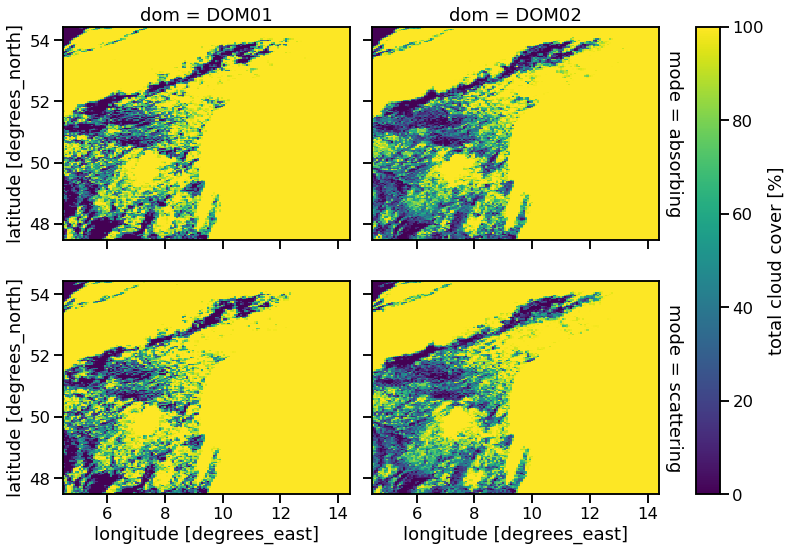

In [10]:
dset['clt'].plot( row = 'mode', col = 'dom', figsize = (12,8))

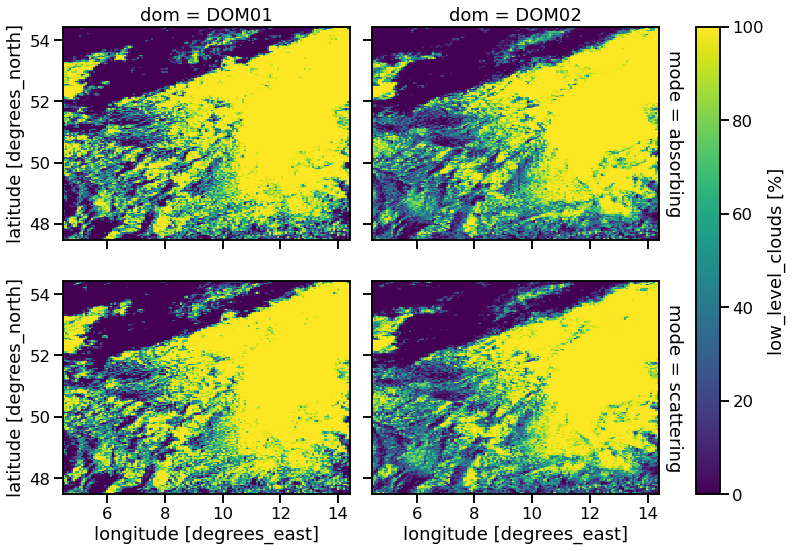

In [11]:
dset['clcl'].plot( row = 'mode', col = 'dom', figsize = (12,8))

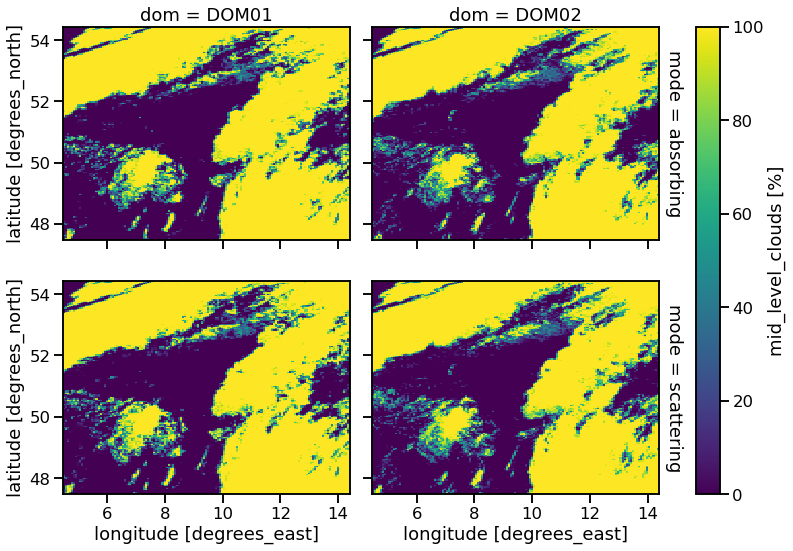

In [12]:
dset['clcm'].plot( row = 'mode', col = 'dom', figsize = (12,8))

### Make a Clearsky Mask based on Total Condensate Threshold

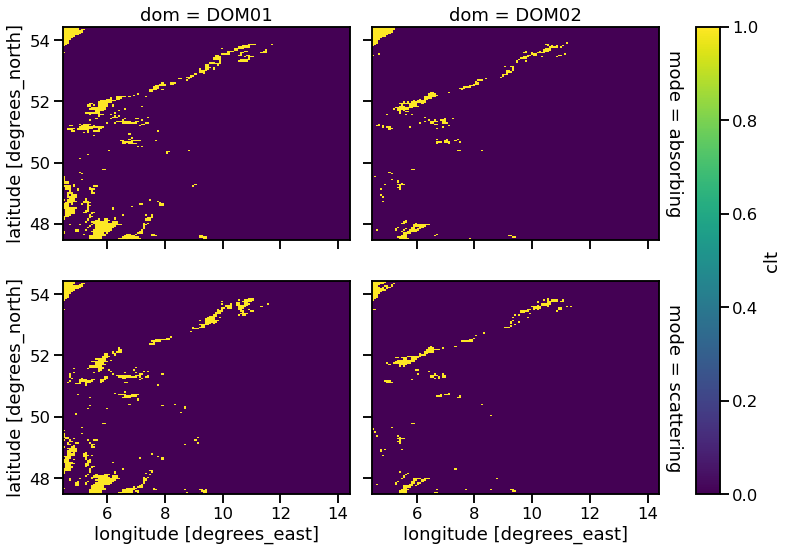

In [13]:
qmask = dset['clt'] == 0.
(qmask).plot( row = 'mode', col = 'dom', figsize = (12,8))

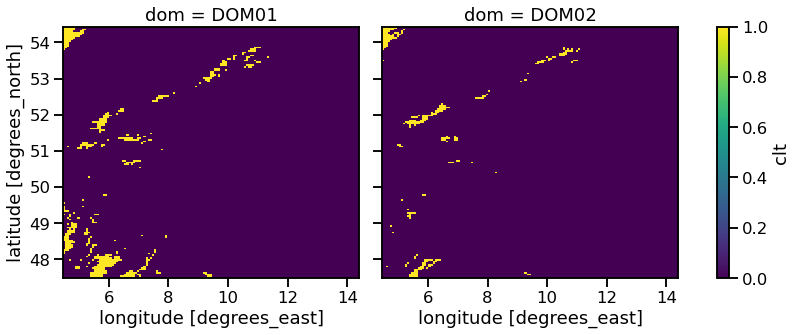

In [14]:
(qmask.prod('mode')).plot( col = 'dom', figsize = (12,5))

## Set Domain-Average Clearsky & Allsky

### Clearsky

In [15]:
qmask = dset['clt'] == 0.
qmask = qmask.prod( ['mode', 'dom'] )
dclear_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [16]:
dclear_domain_mean.compute()

dclear_domain_mean = input_regrid5km.get_difference( dclear_domain_mean )

### Allsky

In [17]:
qmask = dset['clt'] >= 0.
qmask = qmask.prod( ['mode', 'dom'] )
dallsky_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [18]:
dallsky_domain_mean.compute()

dallsky_domain_mean = input_regrid5km.get_difference( dallsky_domain_mean )

### Overcast

In [19]:
qmask = dset['clt'] > 95.
qmask = qmask.prod( ['mode', 'dom'] )
dovercast_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [20]:
dovercast_domain_mean.compute()

dovercast_domain_mean = input_regrid5km.get_difference( dovercast_domain_mean )

### Broken

In [21]:
qmask = ( dset['clt'] > 25. ) & ( dset['clt'] < 75.)
qmask = qmask.prod( ['mode', 'dom'] )
dbroken_domain_mean = dset.where( qmask ).mean( ['lon', 'lat'])

In [22]:
dbroken_domain_mean.compute()

dbroken_domain_mean = input_regrid5km.get_difference( dbroken_domain_mean )

## Plotting

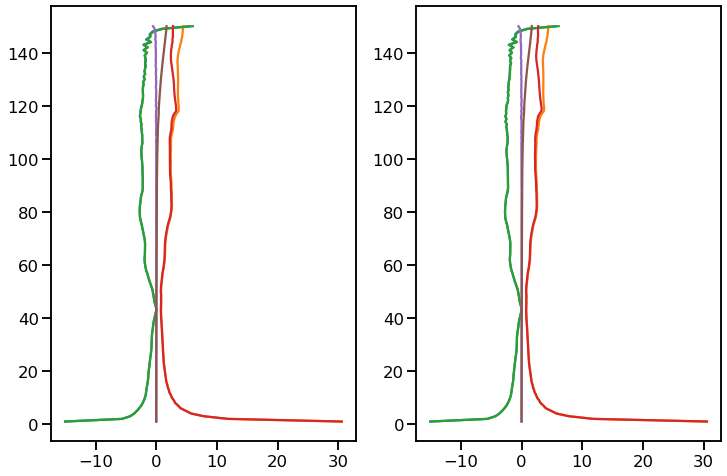

In [23]:
fig, ax = plt.subplots( ncols = 2, figsize = (12,8) )

for mode in dclear_domain_mean.mode : 
    for i, dom in enumerate( dclear_domain_mean.dom ): 
        d = dclear_domain_mean.sel(dom = dom, mode = mode)
        x = 3600 * 24 * d['ddt_temp_radlw']
        y = d['full_level']
        
        plt.sca( ax[i] )
        plt.plot(x, y,  )
        
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = d['full_level']
        
        plt.sca( ax[i] )
        plt.plot(x, y,  )

## Nice Heating Rates Plot

In [24]:
from  input_regrid5km import get_ave_pressure_profile

In [25]:
pm = get_ave_pressure_profile( t )


/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/DATA/3d_coarse_*DOM01*20130502T1100*_regrid5km.nc


/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py:70: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  d = xr.open_mfdataset( flist, chunks = {'time':1} ).squeeze()
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [26]:
pm = pm.rename( {'height_2': 'full_level'})

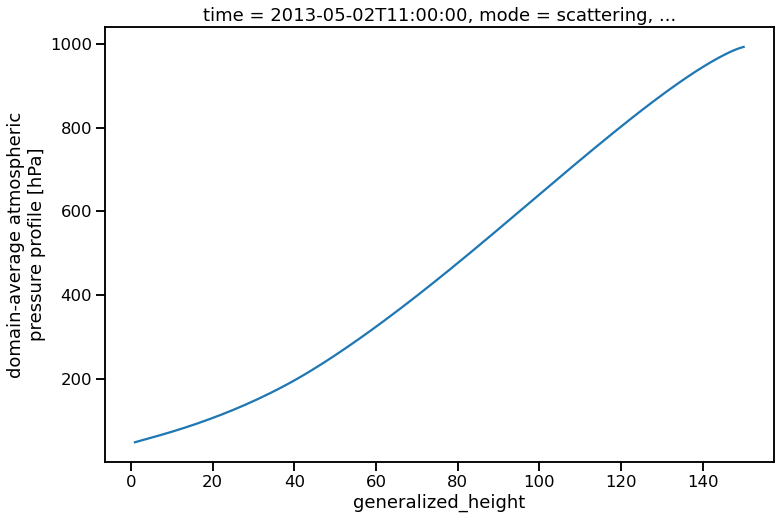

In [27]:
pm.plot()

### Difference in Clearsky

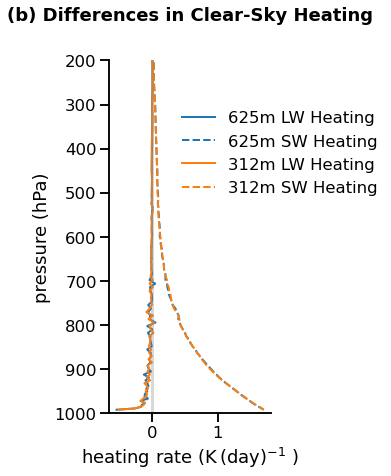

In [55]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)


cols = ['C0', 'C1']
labpre = ['625m', '312m']
mode = 'difference'

for i, dom in enumerate( dclear_domain_mean.dom ): 
        
        # LONGWAVE
        d = dclear_domain_mean.sel(dom = dom, mode = mode).squeeze()
        x = 3600 * 24 * d['ddt_temp_radlw']
        y = pm
        
        plt.plot(x, y, color = cols[i], lw = 2, label = '%s LW Heating' % labpre[i] )

        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = '--', lw = 2, label = '%s SW Heating' % labpre[i] )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)
plt.ylim(1000, 200)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.75, 0.9))
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(b) Differences in Clear-Sky Heating' , fontweight = 'bold', pad = 40 )
plt.savefig('../pics/heating-prof-difference.png', dpi = 300)

### Absolute Profiles in Clearsky

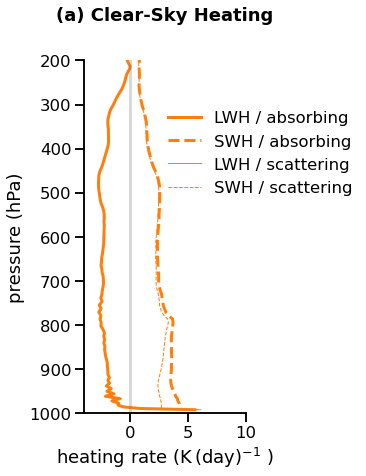

In [56]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)

cols = ['C0', 'C1']
labpre = ['625m', '312m']
lws = [3, 1]
dom = 'DOM02'
for k, mode in enumerate( ['absorbing', 'scattering'] ):
                    # LONGWAVE
                    d = dclear_domain_mean.sel(dom = dom, mode = mode)
                    x = 3600 * 24 * d['ddt_temp_radlw']
                    y = pm

                    plt.plot(x, y, color = cols[i], lw = lws[k], label = 'LWH / %s' % str( mode ))

                    # SHORTWAVE
                    d = dclear_domain_mean.sel(dom = dom, mode = mode)
                    x = 3600 * 24 * d['ddt_temp_radsw']
                    y = pm

                    plt.plot(x, y, color = cols[i], lw = lws[k], ls = '--', label = 'SWH / %s' % mode )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)
plt.ylim(1000, 200)
plt.xlim(-4, 10)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.75, 0.9))
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(a) Clear-Sky Heating' ,  fontweight = 'bold', pad = 40)
plt.savefig('../pics/heating-prof.png', dpi = 300)

### Allsky

In [30]:
mode = 'scattering'

Text(0.5, 1.0, 'Allsky')

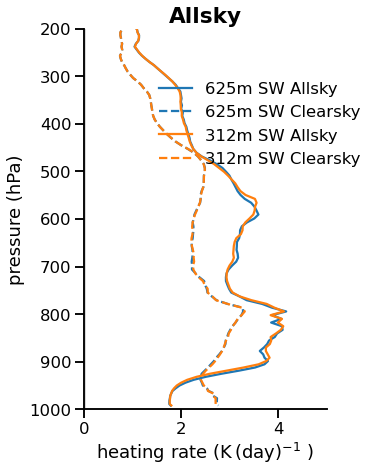

In [31]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )

cols = ['C0', 'C1']
labpre = ['625m', '312m']
for i, dom in enumerate( dclear_domain_mean.dom ): 


        # SHORTWAVE
        d = dallsky_domain_mean.sel(dom = dom, mode = mode)
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = '-', label = '%s SW Allsky' % labpre[i] )

        # SHORTWAVE
        d = dclear_domain_mean.sel(dom = dom, mode = mode)
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = '--', label = '%s SW Clearsky' % labpre[i] )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)

plt.ylim(1000, 200)
plt.xlim(0, 5)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.2, 0.9))
plt.subplots_adjust( right = 0.8)
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( 'Allsky' , fontsize = 'large', fontweight = 'bold')

### Overcast

In [32]:
mode = 'difference'

Text(0.5, 1.0, 'Overcast')

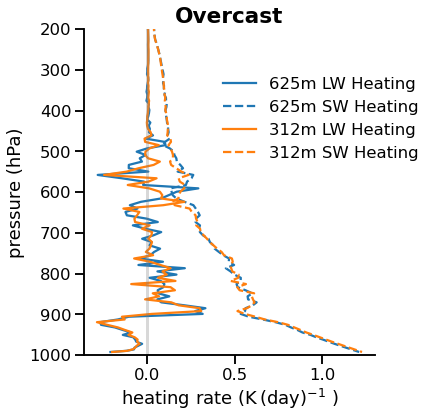

In [33]:
fig, ax = plt.subplots( ncols = 1, figsize = (6,6) )

cols = ['C0', 'C1']
labpre = ['625m', '312m']
for i, dom in enumerate( dclear_domain_mean.dom ): 
        
        # LONGWAVE
        d = dovercast_domain_mean.sel(dom = dom, mode = mode)
        x = 3600 * 24 * d['ddt_temp_radlw']
        y = pm
        
        # print(x,y)
        plt.plot(x, y, color = cols[i], label = '%s LW Heating' % labpre[i] )

        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = '--', label = '%s SW Heating' % labpre[i] )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)

plt.ylim(1000, 200)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.2, 0.9))
plt.subplots_adjust( right = 0.8)
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( 'Overcast' , fontsize = 'large', fontweight = 'bold')

Text(0.5, 1.0, 'SW Heating')

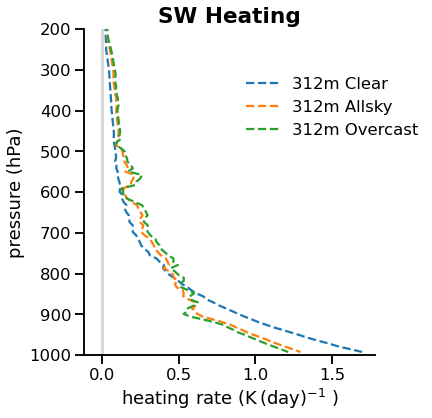

In [34]:
fig, ax = plt.subplots( ncols = 1, figsize = (6,6) )

cols = ['C0', 'C1', 'C2']
labpre = ['625m', '312m']
dom = 'DOM01'

dlist = [dclear_domain_mean, dallsky_domain_mean, dovercast_domain_mean]
lablist = ['Clear', 'Allsky', 'Overcast']

for k, d in enumerate( dlist ):        # LONGWAVE
        d = d.sel(dom = dom, mode = mode)
        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[k], ls = '--', label = '%s %s' % ( labpre[i], lablist[k]) )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)

plt.ylim(1000, 200)
sns.despine()
plt.legend( frameon = False, loc = 'upper right', bbox_to_anchor = (1.2, 0.9))
plt.subplots_adjust( right = 0.8)
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( 'SW Heating' , fontsize = 'large', fontweight = 'bold')

Text(0.5, 1.0, 'Impact of Clouds on SW Heating')

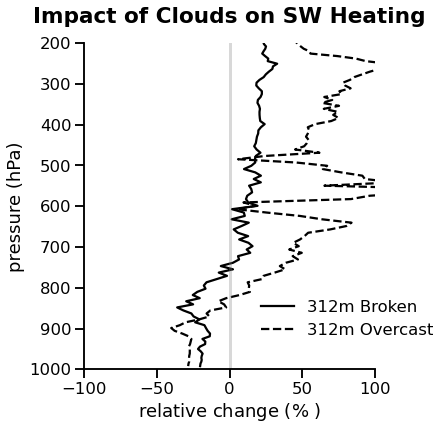

In [35]:
fig, ax = plt.subplots( ncols = 1, figsize = (6,6) )

cols = ['k']*3
labpre = ['625m', '312m']
dom = 'DOM01'
lss = ['-', '--']

dref = dclear_domain_mean

dlist = [( dbroken_domain_mean - dref )/ dref, ( dovercast_domain_mean - dref )/ dref]
lablist = ['Broken', 'Overcast']

for k, d in enumerate( dlist ):        # LONGWAVE
        d = d.sel(dom = dom, mode = mode)
        # SHORTWAVE
        x = 100. * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[k], ls = lss[k], label = '%s %s' % ( labpre[i], lablist[k]) )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)

sns.despine()
plt.ylim(1000, 200)
plt.xlim(-100,100)
plt.legend( frameon = False, loc = 'lower right', bbox_to_anchor = (1.25, 0.05))
plt.subplots_adjust( right = 0.8)
plt.xlabel( 'relative change ($\%$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( 'Impact of Clouds on SW Heating' , fontsize = 'large', fontweight = 'bold', pad = 20)

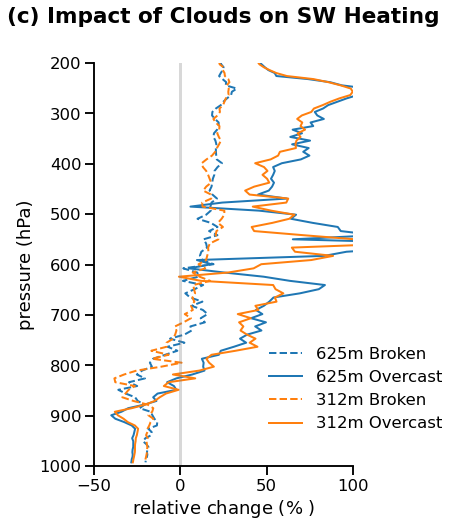

In [36]:
fig, ax = plt.subplots( ncols = 1, figsize = (6,8) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.75, left = 0.2 )

cols = ['C0', 'C1']
labpre = ['625m', '312m']
dom = 'DOM01'
lss = ['--', '-']

dref = dclear_domain_mean

dlist = [( dbroken_domain_mean - dref )/ dref, ( dovercast_domain_mean - dref )/ dref]
lablist = ['Broken', 'Overcast']

for i, dom in enumerate( dref.dom ): 

    for k, drela in enumerate( dlist ):        # LONGWAVE

    # LONGWAVE
        d = drela.sel(dom = dom, mode = mode)
        # SHORTWAVE
        x = 100. * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = lss[k], lw = 2, label = '%s %s' % ( labpre[i], lablist[k]) )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)

sns.despine()
plt.ylim(1000, 200)
plt.xlim(-50,100)
plt.legend( frameon = False, loc = 'lower right', bbox_to_anchor = (1.4, 0.05))
plt.subplots_adjust( right = 0.8)
plt.xlabel( 'relative change ($\%$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(c) Impact of Clouds on SW Heating' , fontsize = 'large', fontweight = 'bold', pad = 40)
plt.savefig('../pics/heating-prof-clouds-impact.png', dpi = 300)

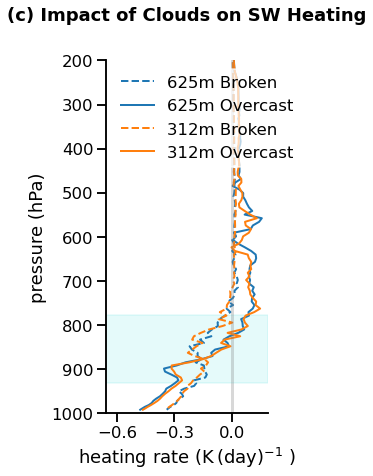

In [54]:
fig, ax = plt.subplots( ncols = 1, figsize = (5,7) )
plt.subplots_adjust( top = 0.85, bottom = 0.15, right = 0.7, left = 0.25)


cols = ['C0', 'C1']
labpre = ['625m', '312m']
dom = 'DOM01'
lss = ['--', '-']

dref = dclear_domain_mean

dlist = [( dbroken_domain_mean - dref ), ( dovercast_domain_mean - dref ) ]
lablist = ['Broken', 'Overcast']

for i, dom in enumerate( dref.dom ): 

    for k, drela in enumerate( dlist ):        # LONGWAVE

    # LONGWAVE
        d = drela.sel(dom = dom, mode = mode)
        # SHORTWAVE
        x = 3600 * 24 * d['ddt_temp_radsw']
        y = pm
        
        plt.plot(x, y, color = cols[i], ls = lss[k], lw = 2, label = '%s %s' % ( labpre[i], lablist[k]) )
        
plt.axvline( 0, lw = 3, color = 'gray', alpha = 0.3)


# include the liquid layer here, copied from notebook 05-Average-TD-profiles and hard-coded...
h1, h2 = 778.1495972842262, 931.0229864211309
plt.axhspan(h1, h2, color='darkturquoise', alpha=0.1)

sns.despine()
plt.ylim(1000, 200)
plt.legend( frameon = True, loc = 'upper left', 
            facecolor = 'white', edgecolor = 'white', 
            framealpha = 0.7)#, bbox_to_anchor = (1.4, 0.05))
plt.xlim(-0.66,)
plt.xticks([-0.6, -0.3,  0] )
plt.xlabel( 'heating rate ($\mathrm{K\,(day)^{-1}}$ )')
plt.ylabel( 'pressure (hPa)')
plt.title( '(c) Impact of Clouds on SW Heating' , fontweight = 'bold', pad = 40)
plt.savefig('../pics/heating-prof-clouds-impact.png', dpi = 300)

## Check Heating Rate Magnitude

We expect the heating rates to represent a term

$$
d_t T \propto \frac{1}{\rho c_P} \partial_z F
$$

Please, note that sign depends on the sign of $F$.

Hence vertical integration across a certain layer allows us to determine the energy gain in terms of flux

$$
F(z_2) - F(z_1) = -\int_{z_1}^{z_2} dz \; \left( \rho\, c_p\, d_t T \right )
= \int_{p_1}^{p_2} dp\; \left( c_p / g \,d_t T\right)
$$

### Profile Data

In [38]:
fdir = '%s/icon-lem/aggregates' % (os.environ['LOCAL_DATA_PATH'],  )
fname = '%s/domain_average_resampled5min.nc' % fdir
dprof = xr.open_dataset( fname ).isel( time = slice(1, 288))
del dprof['lev']

In [39]:
d = dprof.sel(time = '20130502T1100').rename({'height_2':'lev'})

In [40]:
d

<xarray.Dataset>
Dimensions:           (bnds: 2, depth: 8, depth_2: 9, dom: 2, height_2_2: 151, lev: 150, mode: 2)
Coordinates:
  * dom               (dom) object 'DOM01' 'DOM02'
  * mode              (mode) object 'absorbing' 'scattering'
    lon               float64 ...
    lat               float64 ...
    time              datetime64[ns] 2013-05-02T11:00:00
    lev_2             float64 ...
    lev_3             float64 ...
    height            float64 ...
  * lev               (lev) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * depth             (depth) float64 5.0 20.0 60.0 ... 4.86e+03 1.458e+04
  * depth_2           (depth_2) float64 0.0 5.0 20.0 ... 4.86e+03 1.458e+04
    depth_3           float64 ...
  * height_2_2        (height_2_2) float64 1.0 2.0 3.0 4.0 ... 149.0 150.0 151.0
Dimensions without coordinates: bnds
Data variables:
    sob_s             (mode, dom) float64 ...
    sodird_s          (mode, dom) float64 ...
    sodifd_s          (mode, dom) float64 ...
    thb_s             (mode, dom) float64 ...
    thd_s             (mode, dom) float64 ...
    sob_t             (mode, dom) float64 ...
    sod_t             (mode, dom) float64 ...
    thb_t             (mode, dom) float64 ...
    albdif            (mode, dom) float64 ...
    albvisdif         (mode, dom) float64 ...
    albvisdir         (mode, dom) float64 ...
    albnirdif         (mode, dom) float64 ...
    albnirdir         (mode, dom) float64 ...
    lev_bnds          (mode, dom, bnds) float64 ...
    lev_2_bnds        (mode, dom, bnds) float64 ...
    lev_3_bnds        (mode, dom, bnds) float64 ...
    prw               (mode, dom) float64 ...
    clwvi             (mode, dom) float64 ...
    clivi             (mode, dom) float64 ...
    tqr               (mode, dom) float64 ...
    tqs               (mode, dom) float64 ...
    tqg               (mode, dom) float64 ...
    tqh               (mode, dom) float64 ...
    clt               (mode, dom) float64 ...
    z_pbl             (mode, dom) float64 ...
    rain_gsp_rate     (mode, dom) float64 ...
    ice_gsp_rate      (mode, dom) float64 ...
    snow_gsp_rate     (mode, dom) float64 ...
    hail_gsp_rate     (mode, dom) float64 ...
    graupel_gsp_rate  (mode, dom) float64 ...
    hbas_con          (mode, dom) float64 ...
    htop_con          (mode, dom) float64 ...
    cct               (mode, dom) float64 ...
    t_ctop            (mode, dom) float64 ...
    ccb               (mode, dom) float64 ...
    t_cbase           (mode, dom) float64 ...
    clch              (mode, dom) float64 ...
    clcm              (mode, dom) float64 ...
    clcl              (mode, dom) float64 ...
    htop_dc           (mode, dom) float64 ...
    depth_bnds        (mode, dom, depth, bnds) float64 ...
    depth_3_bnds      (mode, dom, bnds) float64 ...
    lhfl_s            (mode, dom) float64 ...
    shfl_s            (mode, dom) float64 ...
    umfl_s            (mode, dom) float64 ...
    vmfl_s            (mode, dom) float64 ...
    t_g               (mode, dom) float64 ...
    ps                (mode, dom) float64 ...
    qv_s              (mode, dom) float64 ...
    tas               (mode, dom) float64 ...
    huss              (mode, dom) float64 ...
    hurs              (mode, dom) float64 ...
    u_10m             (mode, dom) float64 ...
    v_10m             (mode, dom) float64 ...
    mrlsl             (mode, dom, depth) float64 ...
    tsl               (mode, dom, depth_2) float64 ...
    runoff_s          (mode, dom) float64 ...
    t_s               (mode, dom) float64 ...
    t_seasfc          (mode, dom) float64 ...
    tcm               (mode, dom) float64 ...
    tch               (mode, dom) float64 ...
    height_2_bnds     (mode, dom, lev, bnds) float64 ...
    hus               (mode, dom, lev) float64 ...
    clw               (mode, dom, lev) float64 ...
    cli               (mode, dom, lev) float64 ...
    qr                (mode, dom, lev) float64 ...
    qs        

### Air Density

In [41]:
R = 287.
rho = d['pres'] / (R * d['ta'])
rho

<xarray.DataArray (mode: 2, dom: 2, lev: 150)>
array([[[0.07928889, 0.08411015, 0.08837483, 0.09261635, 0.09684443,
         0.10112209, 0.10541891, 0.1097942 , 0.11425029, 0.11881107,
         0.12345056, 0.12819298, 0.13302233, 0.13795996, 0.14298672,
         0.14810739, 0.1532993 , 0.1586086 , 0.16401071, 0.16954149,
         0.1752059 , 0.18100334, 0.18692086, 0.19295745, 0.19911883,
         0.20541646, 0.21186934, 0.21849213, 0.22528849, 0.23227221,
         0.23944432, 0.24680367, 0.25438908, 0.26221242, 0.27029491,
         0.27863678, 0.28724723, 0.29615444, 0.30536682, 0.31486873,
         0.3245807 , 0.33446792, 0.34437334, 0.35424362, 0.36410314,
         0.37371902, 0.38303892, 0.39212636, 0.40099092, 0.40961919,
         0.41807674, 0.42643592, 0.4347175 , 0.44297856, 0.45123819,
         0.45950836, 0.46784892, 0.4761996 , 0.484585  , 0.4929534 ,
         0.5013048 , 0.50966617, 0.51801528, 0.52639771, 0.53482852,
         0.54330816, 0.55187299, 0.56046394, 0.56911543, 0.57776545,
         0.58641629, 0.59502934, 0.60361533, 0.61221191, 0.62080242,
         0.62943589, 0.63808281, 0.64676863, 0.65547792, 0.6642523 ,
         0.67306966, 0.68196358, 0.69086907, 0.69980355, 0.70870467,
         0.7175913 , 0.7264236 , 0.73524823, 0.74403204, 0.75283487,
         0.76160487, 0.77037368, 0.77912245, 0.78788293, 0.79664991,
         0.80541233, 0.81417192, 0.82290066, 0.83161113, 0.84031978,
         0.84901714, 0.8576924 , 0.86635795, 0.87501145, 0.88366556,
         0.89228003, 0.90084179, 0.90937183, 0.91782643, 0.92628876,
         0.93464998, 0.94307334, 0.95150235, 0.96005217, 0.96885088,
         0.97757788, 0.98654572, 0.99514293, 1.00391933, 1.01224694,
         1.02076056, 1.02897577, 1.03733204, 1.04555196, 1.0537576 ,
         1.06189539, 1.07000783, 1.07799242, 1.08589137, 1.09364675,
         1.10135029, 1.10887606, 1.11626517, 1.1234264 , 1.13041043,
         1.13716787, 1.14378377, 1.15017742, 1.15644984, 1.16250457,
         1.16836565, 1.17401402, 1.17933032, 1.18441495, 1.18907805,
         1.19345336, 1.19737342, 1.20082164, 1.20359182, 1.20503955],
        [0.07928743, 0.08411127, 0.08837482, 0.09261612, 0.09684367,
         0.10112137, 0.1054179 , 0.10979215, 0.1142489 , 0.11880947,
         0.12344957, 0.12819236, 0.13302141, 0.13796054, 0.1429882 ,
         0.14810873, 0.1533013 , 0.15861   , 0.16401193, 0.16954324,
         0.17520753, 0.1810046 , 0.18692167, 0.19295798, 0.19911928,
         0.20541661, 0.21186911, 0.21849166, 0.22528855, 0.23227269,
         0.23944542, 0.24680542, 0.25439119, 0.26221549, 0.27029867,
         0.27864088, 0.28725138, 0.29615867, 0.30537108, 0.3148713 ,
         0.32458157, 0.33446903, 0.34436966, 0.35424249, 0.36410167,
         0.37372092, 0.38303998, 0.39212638, 0.40099081, 0.40961889,
         0.41807403, 0.42643575, 0.43471582, 0.44297623, 0.45123213,
         0.4595131 , 0.46784426, 0.47619922, 0.48458405, 0.4929487 ,
         0.501302  , 0.50966335, 0.51801334, 0.52639766, 0.53482472,
         0.54331436, 0.55186852, 0.56046406, 0.56911744, 0.57776409,
         0.58641242, 0.59502392, 0.60361631, 0.61220815, 0.62080871,
         0.62943979, 0.63809524, 0.64677806, 0.6554981 , 0.66426633,
         0.67308963, 0.68196678, 0.69088501, 0.69981019, 0.70871757,
         0.71759334, 0.72642346, 0.73523804, 0.74404716, 0.75286109,
         0.76163629, 0.77040308, 0.7791592 , 0.78791506, 0.79667284,
         0.80543501, 0.81418003, 0.82290184, 0.8316127 , 0.84031044,
         0.84900095, 0.85766758, 0.86633229, 0.87498903, 0.88364332,
         0.89224585, 0.90082514, 0.90932846, 0.91780525, 0.92624901,
         0.9346378 , 0.94303776, 0.95151037, 0.96009241, 0.96890106,
         0.9777375 , 0.98667028, 0.99527724, 1.00399812, 1.01234746,
         1.02082116, 1.02912438, 1.03747029, 1.04570877, 1.05391523,
         1.06206129, 1.07014408, 1.07812616, 1.08598944, 1.09374637,
         1.10139767, 1.10888156, 1.11618418, 1.12327423, 1.13017842,
         1.13688346

### Vertical Integral

In [42]:
d['dp'] = - d['pres'].differentiate('lev')

In [43]:
g = 9.81
cp = 1004.
d['dz'] = - d['dp'] / (g * rho)

In [44]:
d['dz']

<xarray.DataArray 'dz' (mode: 2, dom: 2, lev: 150)>
array([[[365.35216068, 334.99040626, 309.15167415, 295.36948594,
         285.26617785, 277.05587869, 270.15587936, 264.08858299,
         258.68187078, 253.74935098, 249.2449838 , 245.04934218,
         241.14663655, 237.45938958, 233.98412378, 230.6728762 ,
         227.54210154, 224.19069518, 220.96255377, 218.45127631,
         216.0540409 , 213.45318502, 210.9397248 , 208.50469021,
         206.14264558, 203.84820226, 201.61364081, 199.43371432,
         197.30951534, 195.23275228, 193.20311627, 191.22546285,
         189.28445411, 187.38484237, 185.51900136, 183.69048438,
         181.89897488, 180.13636972, 178.40037248, 176.68507817,
         175.00451121, 173.33400079, 171.70177939, 170.10211781,
         168.49436709, 166.92975254, 165.39734709, 163.87829224,
         162.37682648, 160.90264347, 159.44750052, 158.00481916,
         156.58190593, 155.17129526, 153.77531435, 152.39743121,
         151.0236199 , 149.67050551, 148.32422831, 146.99449466,
         145.67834858, 144.36989233, 143.07727646, 141.79324153,
         140.51850505, 139.25542126, 137.99614661, 136.75228845,
         135.51127803, 134.28296511, 133.06014721, 131.84813334,
         130.64522855, 129.44618233, 128.25722554, 127.07148912,
         125.8949037 , 124.72196213, 123.55836874, 122.39710906,
         121.24389009, 120.0918302 , 118.94813218, 117.80647062,
         116.67324149, 115.54188103, 114.4188024 , 113.2968098 ,
         112.18243356, 111.06824681, 109.9607657 , 108.85515237,
         107.75496349, 106.65639792, 105.56063857, 104.4685604 ,
         103.3780956 , 102.29121317, 101.20638613, 100.12199488,
          99.03912352,  97.95868546,  96.87982924,  95.80249927,
          94.72502642,  93.64940832,  92.5750252 ,  91.49954298,
          90.42718912,  89.34873161,  88.27549499,  87.19485325,
          86.11567603,  85.03520754,  83.94278943,  82.86104214,
          81.75626917,  80.67143643,  79.55766017,  78.46217988,
          77.33809754,  76.22453495,  75.08883881,  73.95047322,
          72.79797862,  71.63450025,  70.4550356 ,  69.26275361,
          68.05157141,  66.82405957,  65.57136851,  64.29755682,
          62.99548655,  61.66492971,  60.29869247,  58.89479937,
          57.44254492,  55.93922973,  54.37181886,  52.73256196,
          51.00595581,  49.17256297,  47.21069456,  45.07996174,
          42.73453527,  40.08886946,  37.00488147,  33.07993203,
          27.4321988 ,  24.03208054],
        [365.35763117, 334.98654014, 309.15255512, 295.36913883,
         285.26687363, 277.05585621, 270.15541249, 264.08965433,
         258.68133077, 253.74983538, 249.24497552, 245.04879132,
         241.14736865, 237.45912566, 233.98344687, 230.67346908,
         227.54173941, 224.1905918 , 220.96272473, 218.45108677,
         216.05429415, 213.45307709, 210.9396061 , 208.50515357,
         206.14267836, 203.84804899, 201.61362875, 199.43391277,
         197.30946072, 195.23277639, 193.20305581, 191.22551913,
         189.28445018, 187.38473601, 185.51900126, 183.69064067,
         181.89911459, 180.13615038, 178.40048929, 176.68553227,
         175.00465509, 173.3331298 , 171.70274569, 170.10153425,
         168.49477668, 166.92943625, 165.39740702, 163.87828249,
         162.37687166, 160.90276156, 159.44781878, 158.00441623,
         156.58205502, 155.17098782, 153.77649726, 152.39564065,
         151.02491274, 149.67020932, 148.32410808, 146.99488635,
         145.67796909, 144.37030175, 143.07781395, 141.79287742,
         140.51912895, 139.25420059, 137.99726334, 136.75190376,
         135.51115057, 134.28293823, 133.0603465 , 131.84899797,
         130.64435631, 129.44697866, 128.25720951, 127.07228299,
         125.89432315, 124.72291453, 123.55760204, 122.39782043,
         121.24325175, 120.09330936, 118.94740503, 117.80706064,
         116.67252134, 115.54238526, 114.41855017, 113.29865087,
         112.1822946 , 111.06808079, 109.96067415, 108.85564965,
         1

In [45]:
d['dz'].integrate( 'lev')

<xarray.DataArray 'dz' (mode: 2, dom: 2)>
array([[20533.46454179, 20533.46547791],
       [20533.47884535, 20533.47914174]])
Coordinates:
  * dom      (dom) object 'DOM01' 'DOM02'
  * mode     (mode) object 'absorbing' 'scattering'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

### Integral for Clearsky Shortwave Radiation

In [46]:
swh = dclear_domain_mean['ddt_temp_radsw']
del swh['lev']
swh = swh.rename({'full_level':'lev'})


In [47]:
heating_rate_integral = ( cp / g * d['dp'] * swh ).integrate( 'lev' )
heating_rate_integral.compute()

<xarray.DataArray (mode: 2, dom: 2)>
array([[-267.73736252, -267.91790595],
       [-237.26435934, -237.47615443]])
Coordinates:
  * mode     (mode) object 'absorbing' 'scattering'
  * dom      (dom) object 'DOM01' 'DOM02'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

In [48]:
heating_rate_integral.diff('mode').compute()

<xarray.DataArray (mode: 1, dom: 2)>
array([[30.47300318, 30.44175152]])
Coordinates:
  * mode     (mode) object 'scattering'
  * dom      (dom) object 'DOM01' 'DOM02'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

### Integral for Allsky Shortwave Radiation

In [49]:
swh = dallsky_domain_mean['ddt_temp_radsw']
del swh['lev']
swh = swh.rename({'full_level':'lev'})


In [50]:
heating_rate_integral = ( cp / g * d['dp'] * swh ).integrate( 'lev' )
heating_rate_integral.compute()

<xarray.DataArray (mode: 2, dom: 2)>
array([[-324.60832574, -323.44629898],
       [-295.39193035, -294.35883214]])
Coordinates:
  * mode     (mode) object 'absorbing' 'scattering'
  * dom      (dom) object 'DOM01' 'DOM02'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

In [51]:
heating_rate_integral.diff('mode').compute()

<xarray.DataArray (mode: 1, dom: 2)>
array([[29.21639539, 29.08746684]])
Coordinates:
  * mode     (mode) object 'scattering'
  * dom      (dom) object 'DOM01' 'DOM02'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

### Comparison with Allsky Difference

In [52]:
 d['sob_s'] - d['sob_t'] 

<xarray.DataArray (mode: 2, dom: 2)>
array([[-226.73822021, -232.46655273],
       [-206.51968384, -211.82592773]])
Coordinates:
  * dom      (dom) object 'DOM01' 'DOM02'
  * mode     (mode) object 'absorbing' 'scattering'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0

In [53]:
(d['sob_s'] - d['sob_t'] ).diff('mode')

<xarray.DataArray (mode: 1, dom: 2)>
array([[20.21853638, 20.640625  ]])
Coordinates:
  * dom      (dom) object 'DOM01' 'DOM02'
  * mode     (mode) object 'scattering'
    lon      float64 0.0
    lat      float64 0.0
    time     datetime64[ns] 2013-05-02T11:00:00
    lev_2    float64 400.0
    lev_3    float64 800.0
    height   float64 2.0
    depth_3  float64 0.0